#  Analysing the effects of PSO parameters on fitness

## Libraries , helper functions, and data loading

In [7]:
# Libraries and helper functions
import pickle
import json
import sys
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

def get_config(file='config.json'):
    with open(file) as cfg_file:  
     return json.load(cfg_file)

def get_all_pso_config_results(cfg, filepath):
    # A bit messy. Creates a table of resulted fitness for each algorithm configuration on each month
    with open(filepath) as cfg_file:  
     pso_cfg = json.load(cfg_file)
    df = pd.DataFrame(columns=['config name','data file','mdd', 'no_of_short_selling_transactions', 'no_of_transactions', 'noop', 'realised_profit', 'ret', 'u_buy', 'u_sell', 'value', 'wealth'])
    for config in pso_cfg:
        for f in cfg['data']['files']:
            fp = pso_cfg[config]['base_results_file_path'] + f + '/pickles/average_fitness.pickle'
            p = pd.Series(pickle.load(open(fp,"rb")), name=(config+' '+f))
            p['config name'] = config
            p['data file'] = f
            df = df.append(p)
    return df

def get_configurations(data, names):
    """
        Returns df on each test month with all configs of the names array
    """
    df = pd.concat(data.loc[data['config name'] == n] for n in names)
    return df.loc[df['data file'] == 'data/fx-spot_EUR_GBP_10min_201306.txt:fx-spot_EUR_GBP_10min_201306:02:20:21:28'][['config name', 'value']].set_index('config name'), df.loc[df['data file'] == 'data/fx-spot_EUR_GBP_10min_201307.txt:fx-spot_EUR_GBP_10min_201307:0:20:21:30'][['config name', 'value']].set_index('config name'), df.loc[df['data file'] == 'data/fx-spot_EUR_GBP_10min_201308.txt:fx-spot_EUR_GBP_10min_201308:0:20:21:29'][['config name', 'value']].set_index('config name')

def plot_train_months(june, july, august):
    plt.plot(june)
    plt.plot(july)
    plt.plot(august)
    plt.legend(['june', 'july', 'august'])
    plt.xticks(rotation=20)
    plt.xlabel('Configurations', size=14)
    plt.ylabel('Fitness value', size=14)


In [8]:
# Load data
cfg = get_config()
pso_configs = get_all_pso_config_results(cfg, './config/algos/pso_param_exp_configs.json')

FileNotFoundError: [Errno 2] No such file or directory: 'results/pso/sss/data/fx-spot_EUR_GBP_10min_201309.txt:fx-spot_EUR_GBP_10min_201309:0:20:21:29/pickles/average_fitness.pickle'

## Swarm size analysis

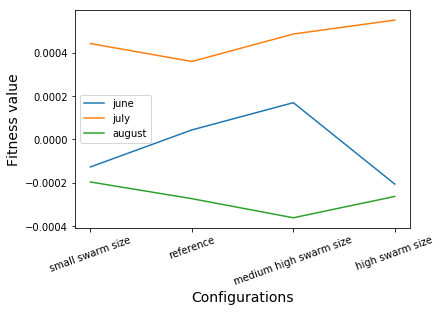

In [68]:
p_configs = ['small swarm size', 'reference', 'medium high swarm size', 'high swarm size']
june, july, august = get_configurations(pso_configs, p_configs)
plot_train_months(june, july, august)

## Max velocity analysis

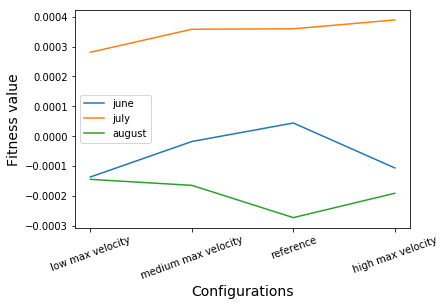

In [69]:
p_configs = ['low max velocity', 'medium max velocity', 'reference', 'high max velocity']
june, july, august = get_configurations(pso_configs, p_configs)
plot_train_months(june, july, august)

## Inertia weight analysis

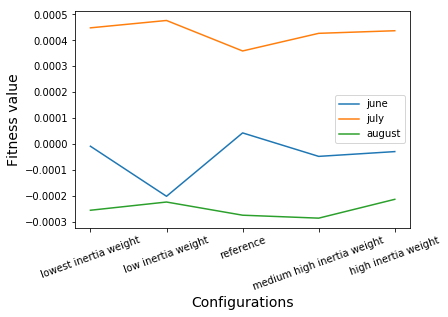

In [70]:
p_configs = ['lowest inertia weight', 'low inertia weight', 'reference', 'medium high inertia weight', 'high inertia weight']
june, july, august = get_configurations(pso_configs, p_configs)
plot_train_months(june, july, august)

## Memory weight analysis

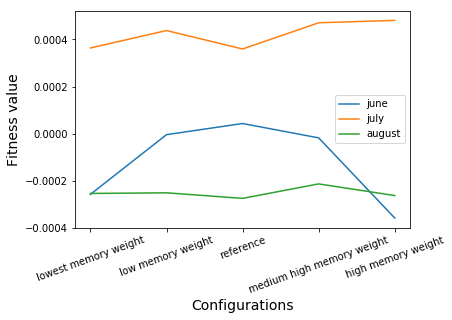

In [71]:
p_configs = ['lowest memory weight', 'low memory weight', 'reference', 'medium high memory weight', 'high memory weight']
june, july, august = get_configurations(pso_configs, p_configs)
plot_train_months(june, july, august)

## Neighbour weight analysis

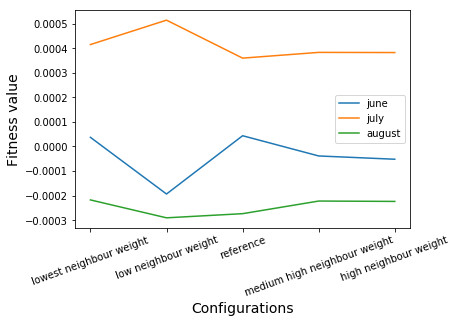

In [72]:
p_configs = ['lowest neighbour weight', 'low neighbour weight', 'reference', 'medium high neighbour weight', 'high neighbour weight']
june, july, august = get_configurations(pso_configs, p_configs)
plot_train_months(june, july, august)

# Convergence param analysis

These parameters define the convergence of the algorithm. 
They allow us to tune wether we favor local exploitation or not. If we converge too early, our models will be too general. If we converge too late, our models will overfit.

## K analysis

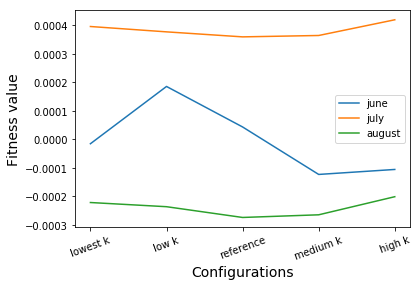

In [73]:
p_configs = ['lowest k', 'low k', 'reference', 'medium k', 'high k']
june, july, august = get_configurations(pso_configs, p_configs)
plot_train_months(june, july, august)

## Velocity convergence threshold analysis

When the velocity convergence threshold is reached in a run of PSO, the algorithm assumes convergence, stops training, and yields its best candidate.

I hypothesise that the lower the velocity convergence threshold is, the smaller the velocity of each particle has to be to assume convergence, and thus the better the individuals, because it allows exploitation of a local optimum.

We thus propose 5 different configurations and run them on the test data:

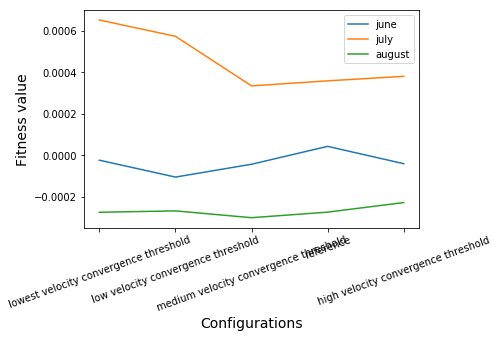

In [74]:
p_configs = ['lowest velocity convergence threshold', 'low velocity convergence threshold', 'medium velocity convergence threshold', 'reference', 'high velocity convergence threshold']
june, july, august = get_configurations(pso_configs, p_configs)
plot_train_months(june, july, august)

We can see that the best results occur when the velocity convergence threshold is lowest. Our hypothesis is confirmed.
It is interesting to note that high threshold seem to perform better than medium thresholds. My theory is that medium thresholds get the worst of two worlds: they are in an optimum but are not specialised enough, so they benefit of neither exploration or exploitation.

## Max iteration analysis

Max iteration defines the number of velocity updates we allow for each particle. It is the opposite of the velocity convergence threshold: the higher the max iteration, the more we allow our particles to be updated, and the more local exploitation occurs.

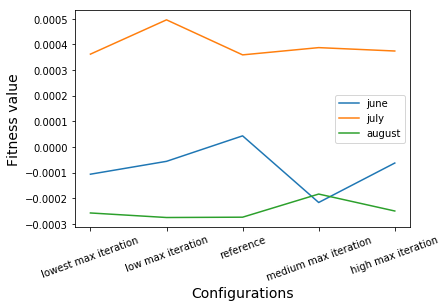

In [75]:
p_configs = ['lowest max iteration', 'low max iteration', 'reference', 'medium max iteration',  'high max iteration']
june, july, august = get_configurations(pso_configs, p_configs)
plot_train_months(june, july, august)

# Conclusion of paramater analysis

This analysis allowed us to test the hypotheses of the influence of parameters on fitness generation.
We see that, in order to have better fitness on the testing data, assuming that each parameter is independant we want;

- A medium to high swarm size
- A medium max velocity
- A high inertia weight
- A medium memory weight
- A low or high neighbourhood weight
- A low velocity convergence threshold
- A low or high k
- A low or high max iteration

My interpretations of these results, in layman terms, are ;
We can maximise our fitness by giving the algorithm high resources (swarm size, low velocity convergence)
We can maximise our fitness by either favoring exploration (low or high weights, low or high k and max iter)

So my strategy is to approach the PSO configuration through four setups:

- An exploratory and cheap setup
- An exploratory and expensive setup


- An exploitatory and cheap setup
- An exploitatory and expensive setup



# Proposed combinatorial setups

I time each setup since we now take into account expensiveness of computation

## Reference
Stays the same

## Exploratory cheap
To favour exploration, we set a low neighbourhood weight, a medium memory weight, a high inertia weight, a low k, a low max iteration

To favor cheapness, we set a low swarm size, and a high velocity convergence threshold

## Exploratory expensive
To favour exploration, we set a low neighbourhood weight, a medium memory weight, a high inertia weight, a low k, a low max iteration

To favor expensiveness, we set a high swarm size, and a low velocity convergence threshold

## Exploitatory cheap
To favour exploitation, we set a high neighbourhood weight, a low memory weight, a medium inertia weight, a high k, a high max iteration

To favor cheapness, we set a low swarm size, and a high velocity convergence threshold


## Exploitatory expensive
To favour exploitation, we set a high neighbourhood weight, a medium memory weight, a low inertia weight, a high k, a high max iteration

To favor expensiveness, we set a high swarm size, and a low velocity convergence threshold


# Testing the proposed paramater combination setups

timings: 

- reference:  84.93s user 14.93s system 75% cpu 2:11.92 total
- exploratory cheap:  26.42s user 4.29s system 74% cpu 41.238 total
- exploratory expensive:  2553.77s user 454.76s system 77% cpu 1:04:49.45 total
- exploitatory cheap:  172.00s user 35.54s system 61% cpu 5:39.31 total
- exploitatory expensive: 1825.04s user 387.97s system 75% cpu 48:44.36 total



In [4]:
# Load and group results
test_configs = get_all_pso_config_results(cfg, './config/algos/pso_configs.json')
p_configs = ['reference', 'exploratory cheap', 'exploratory expensive', 'exploitatory cheap',  'exploitatory expensive']
june, july, august = get_configurations(test_configs, p_configs)
june['month'] = 'june'
july['month'] = 'july'
august['month'] = 'august'
fitnesses = june.append(july.append(august))
print(fitnesses)

                           value   month
config name                             
reference               0.000044    june
exploratory cheap      -0.000040    june
exploratory expensive   0.000322    june
exploitatory cheap      0.000426    june
exploitatory expensive  0.000484    june
reference               0.000359    july
exploratory cheap       0.000363    july
exploratory expensive   0.000656    july
exploitatory cheap      0.000378    july
exploitatory expensive  0.000469    july
reference              -0.000274  august
exploratory cheap      -0.000210  august
exploratory expensive  -0.000367  august
exploitatory cheap     -0.000064  august
exploitatory expensive -0.000413  august


(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

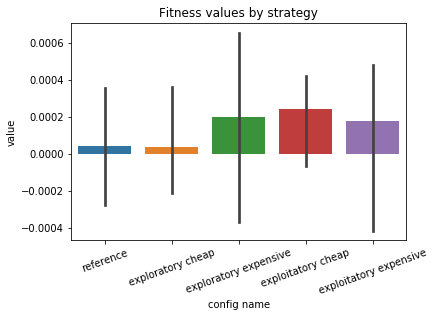

In [5]:
df = fitnesses.reset_index()

p = sns.barplot(x='config name', y='value', data=df).set_title('Fitness values by strategy')
plt.xticks(rotation=20)


(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

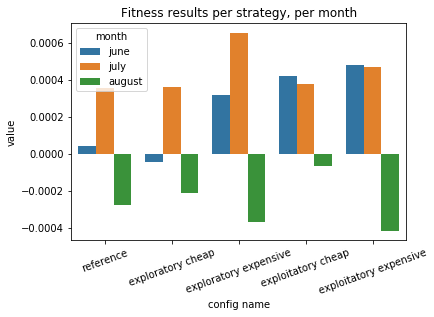

In [6]:
p = sns.barplot(x='config name', y='value', data=df, hue='month').set_title('Fitness results per strategy, per month')
plt.xticks(rotation=20)

We have some interesting results!

First of all, it seems that for the month of july, most strategies perform relatively well.

When comparing the results for june, we can see that exploitation is much more favored than exploration. 

For the month of august, only the exploitatory cheap strategy seems to minimise our losses. It's peculiar that expensive strategies perform less well on the month of august, maybe the exploitatory cheap limits overfitting by lacking resources.

Overall, the exploitatory cheap strategy seems to perform the best of the 5 strategies. It seems to generate consequent returns on the good months (july, june), and limit losses on the bad month (august).

It could be interesting to compare these results with the GA results, or with PSO results, to see if the performance is correlated to the trend of the market in a certain month or if the strategy is not adapted for certain months.
